Libraries

In [110]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

Network Architecture

In [111]:
activation_map = {

    'tanh' : nn.Tanh(),
    'relu' :  nn.ReLU(),
    'sigmoid' : nn.Sigmoid(),
    'none' : None,
    'None': None

}


class PINNet(nn.Module):
    def __init__(self, layers, activation):
        super().__init__()
        if len(activation)==len(layers):
            layer_list=[]
            activation_model= [activation_map[act] for act in activation]
            for i in range(1, len(activation)):
                layer_list.append(nn.Linear(layers[i-1], layers[i]))
                if activation_model[i] is not None:
                    layer_list.append(activation_model[i])

            self.network = nn.Sequential(*layer_list)

    def forward(self,*args):
        out = torch.cat(args, dim=1)
        return self.network(out)

Optimizer Functions

In [112]:
def optimizer(opt, parameters, lr):

    optima= getattr(torch.optim, opt)
    optimize = optima(parameters, lr=lr)

    return optimize

Xavier Weight Initialization

In [113]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

Gradient Functions

In [114]:
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def hessian(y, x):
    z = grad(y, x)
    return torch.autograd.grad(z, x, grad_outputs=torch.ones_like(z), create_graph=True)[0]

In [115]:
import torch
import os

def save_checkpoint(path, model, optimizer, ic_loss, bc_loss, pde_loss, epoch, loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),     
        'optimizer_state_dict': optimizer.state_dict(), 
        'ic_loss': ic_loss,
        'bc_loss': bc_loss,
        'pde_loss': pde_loss,
        'loss': loss
    }, path)
    print(f"Checkpoint saved at {path}")

def load_checkpoint(path, model, optimizer):
    if not os.path.exists(path):
        print(f" No checkpoint found at {path}, starting fresh.")
        return 0, float('inf')

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f" Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4e}")
    return checkpoint['epoch'], checkpoint['loss']

Diffusivity (piecewise)

In [116]:
t_time =408
def time_dependent_theta(z, t):
    t_hours = t*t_time
    # Base value
    theta1 = 0.22
    theta2 = 0.18
    base_theta =torch.where(z <= 0.25, theta1, theta2)
    variation = 0.05 * torch.sin(2 * np.pi * t_hours / 24)  # Daily cycle
    return base_theta + variation

def diffusivity(z, t):
    theta = time_dependent_theta(z, t)
    theta_percent = theta * 100
    alpha_1 = 0.23 + 0.25 / (1 + torch.exp(-0.78 * (theta_percent - 11.3)))
    alpha_2 = 0.25 + 0.64 / (1 + torch.exp(-1.72 * (theta_percent - 6.01)))
    alpha_mm2s = torch.where(z <= 0.25,  alpha_1, alpha_2 )
    
    return alpha_mm2s * 1e-6  # Convert mm²/s to m²/s

def heat_source(x, t):
    Area = 2
    depth =0.02
    t_cap = 1800*800*Area*depth
    Q1 = 50 / t_cap   # scaled heat source
    Q2 = 30 / t_cap
    Q3 = 10 / t_cap 
    Q_layer = torch.where((x>=0.84)&(x<0.86), torch.ones_like(x), torch.zeros_like(x))  
    Q_on = torch.where(
        t <= (3/17), Q1*torch.ones_like(t), 
        torch.where(
            (t>=7/17)&(t<=10/17), Q2*torch.ones_like(t), 
            torch.where(
                (t>=14/17)&(t<=1), Q3*torch.ones_like(t), 
                torch.zeros_like(t)
            )
        )
    )
    return Q_layer*Q_on

Input

In [117]:
z_min, z_max = 0.0, 0.95
t_min, t_max = 0.0, 1.0
T0 = 18.0  # initial temp

N_f = 10000
z_f = torch.rand((N_f,1))*0.95
t_f = torch.rand((N_f,1))

N_ic = 200
z_ic = torch.rand((N_ic,1))*0.95
t_ic = torch.zeros_like(z_ic)
T_ic = torch.ones_like(z_ic) * T0

N_bc = 5000
z_bc_top = torch.zeros((N_bc//2,1))*0.95
t_bc_top = torch.rand((N_bc//2,1))

def temp(t):
    T = 15.0
    t_hours = t*408
    p = 24
    amp =5
    sine_wave = amp* torch.sin(2*np.pi * t_hours/(p) - np.pi/2)
    return T + sine_wave

z_bc_bot = torch.ones((N_bc//2,1))*0.95
t_bc_bot = torch.rand((N_bc//2,1))

Loss Function

In [118]:
# PDE residual
def pde_residual(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    tau = 408*3600
    T = model(x, t)
    T_t = grad(T, t)
    T_xx = hessian(T, x)
    alpha = diffusivity(x, t)
    Q = heat_source(x, t)
    
    pde_loss = torch.mean(((T_t - tau*(alpha * T_xx + Q))**2))
    return pde_loss

In [119]:
def ic_loss(model, x0, t0, T0):
    return torch.mean((model(x0, t0) - T0) ** 2)

In [120]:
def bc_loss_top(model, x_b, t_b):
    x_b.requires_grad_(True)
    t_b.requires_grad_(True)
    T = model(x_b, t_b)
    T_top = temp(t_b)
    return torch.mean((T- T_top) ** 2)

In [121]:
def bc_loss(model, x_b, t_b):
    x_b.requires_grad_(True)
    t_b.requires_grad_(True)
    T = model(x_b, t_b)
    T_x = grad(T, x_b)
    return torch.mean(T_x ** 2)

In [122]:
def loss_function(model, x0, t0, T0, x_b0, t_b0, x_b1, t_b1, x_f, t_f, epoch):
    ic = ic_loss(model, x0, t0, T0)
    bc = bc_loss_top(model, x_b0, t_b0) + bc_loss(model, x_b1, t_b1)
    pde = pde_residual(model, x_f, t_f)
    total = 10*bc + 10*ic + pde
    return total, ic.item(), bc.item(), pde.item()

Model Creation

In [123]:
model = PINNet([2, 64, 64, 64, 64, 64, 64, 1], ['none', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'none'])
model.apply(init_weights)
optim = optimizer('Adam', model.parameters(), lr=0.001)

In [124]:
checkpoint_path = '/home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth'
start_epoch, best_loss = load_checkpoint(checkpoint_path, model, optim)

 Loaded checkpoint from epoch 25000 with loss 2.8393e+02


/w0/tmp/slurm_ug611257.61249892/ipykernel_2991571/2245481268.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [125]:
# Training
epoch_history = []
ic_history = []
bc_history = []
pde_history = []
total_history =[]

for epoch in range(25001):
    optim.zero_grad()
    
    loss, ic, bc, pde  = loss_function(model, z_ic, t_ic, T_ic, z_bc_top,t_bc_top, z_bc_bot, t_bc_bot, z_f, t_f, epoch)

    loss.backward()
    
    optim.step()

    if (epoch+1)%1000==0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5e}, PDE: {pde:.5e}, IC: {ic:.5e}, BC: {bc:.5e}")
        epoch_history.append(epoch+1)
        ic_history.append(ic)
        bc_history.append(bc)
        pde_history.append(pde)
        total_history.append(loss.item())
        save_checkpoint(checkpoint_path, model, optim, ic, bc, pde, epoch+1, loss.item())

Epoch 1000, Loss: 3.31689e+02, PDE: 1.99469e+02, IC: 6.67271e-02, BC: 1.31552e+01
Checkpoint saved at /home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth
Epoch 2000, Loss: 4.32440e+02, PDE: 3.02448e+02, IC: 5.42839e-02, BC: 1.29449e+01
Checkpoint saved at /home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth
Epoch 3000, Loss: 2.87531e+02, PDE: 1.59490e+02, IC: 5.41618e-02, BC: 1.27499e+01
Checkpoint saved at /home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth
Epoch 4000, Loss: 2.37500e+02, PDE: 1.10541e+02, IC: 5.69407e-02, BC: 1.26390e+01
Checkpoint saved at /home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth
Epoch 5000, Loss: 2.29435e+02, PDE: 1.03797e+02, IC: 5.16987e-02, BC: 1.25121e+01
Checkpoint saved at /home/ug611257/jupyterlab/ground_heat/checkpoint/case_VII_checkpoint_1.pth
Epoch 6000, Loss: 2.96489e+02, PDE: 1.72285e+02, IC: 5.64476e-02, BC: 1.23640e+01
Checkpoint saved at /home/ug61125

In [126]:
# Plotting at t = 1.0
x_plot = torch.linspace(0, 1, 200).view(-1, 1)*0.95
t_plot = torch.ones_like(x_plot)
T_pred = model(x_plot, t_plot).detach().cpu().numpy()
x_np = x_plot.cpu().numpy()

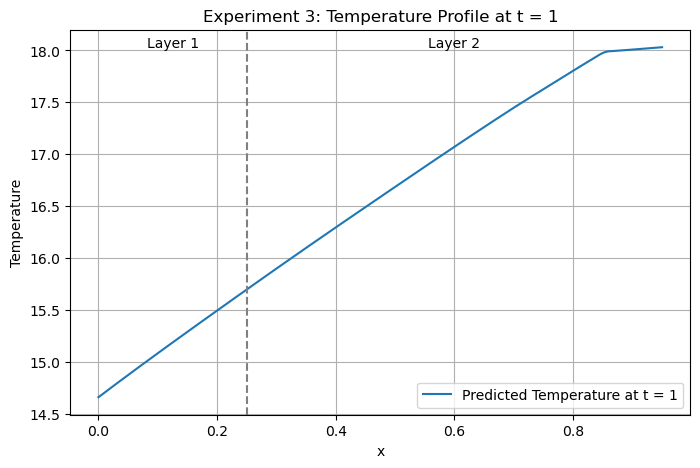

In [127]:
plt.figure(figsize=(8, 5))
plt.plot(x_np, T_pred, label="Predicted Temperature at t = 1")
plt.axvline(x=0.25, color='gray', linestyle='--')
plt.text(0.125, T_pred.max(), 'Layer 1', ha='center')
plt.text(0.6, T_pred.max(), 'Layer 2', ha='center')
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Experiment 3: Temperature Profile at t = 1")
plt.legend()
plt.grid(True)
plt.show()

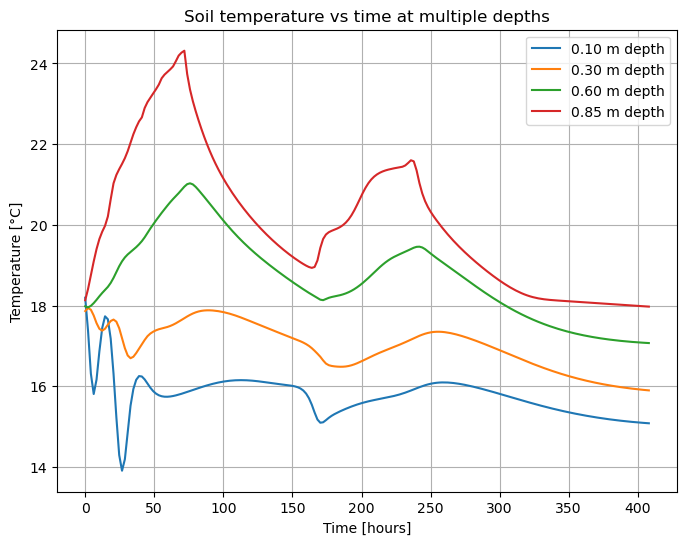

In [128]:
# --------------------------
# Generate prediction points
# --------------------------
model.eval()
with torch.no_grad():
    n_time = 200
    t_plot = torch.linspace(0,1,n_time).view(-1,1)
    depths = [0.1, 0.3, 0.6, 0.85]  # scaled depths
    T_results = []
    for d in depths:
        z_plot = torch.ones_like(t_plot) * d
        T_pred = model(z_plot, t_plot).cpu().numpy().flatten()
        T_results.append(T_pred)

# Convert time back to hours
t_hours = (t_plot.numpy().flatten() * t_time)

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(8,6))
for i, d in enumerate([0.1,0.3,0.6,0.85]):
    plt.plot(t_hours, T_results[i], label=f"{d:.2f} m depth")
plt.xlabel("Time [hours]")
plt.ylabel("Temperature [°C]")
plt.title("Soil temperature vs time at multiple depths")
plt.legend()
plt.grid()
plt.show()


In [129]:
t_plot = torch.linspace(0, 1, 200).view(-1, 1)
x_plot = 0.85*torch.ones_like(t_plot)
T_pred = heat_source(x_plot, t_plot).detach().cpu().numpy()
t_np = t_plot.cpu().numpy()*t_time

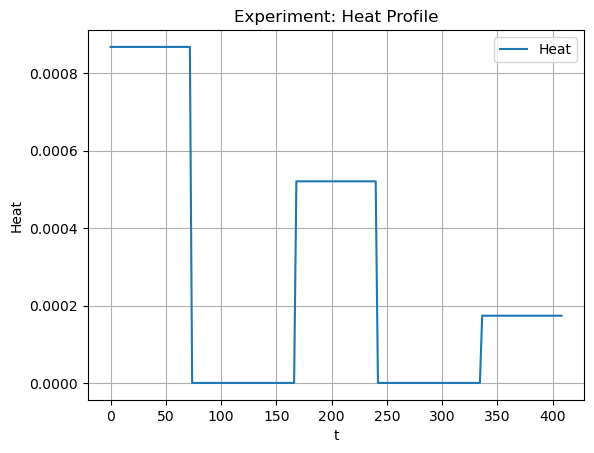

In [130]:
plt.plot(t_np, T_pred, label="Heat")
plt.xlabel("t")
plt.ylabel("Heat")
plt.title("Experiment: Heat Profile")
plt.legend()
plt.grid(True)
plt.show()

In [131]:
time = torch.linspace(0, 1, 200).view(-1, 1)
z_alpha1 = torch.full((200, 1), 0.1)  # 0.1m (in layer 1)
z_alpha2 = torch.full((200, 1), 0.5)  # 0.5m (in layer 2)
alpha1_pred = diffusivity(z_alpha1, time).detach().cpu().numpy()
alpha2_pred = diffusivity(z_alpha2, time).detach().cpu().numpy()
time_np = time.cpu().numpy()*t_time

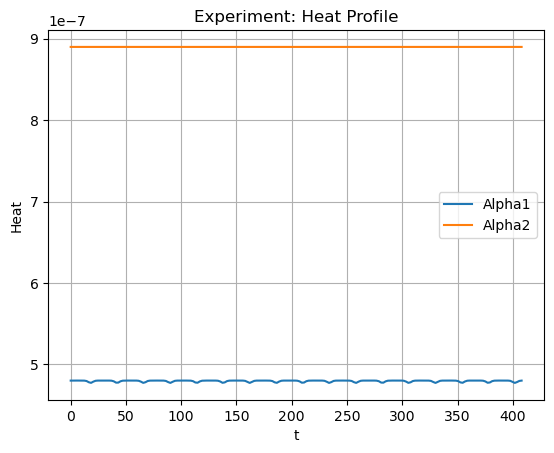

In [132]:
plt.plot(time_np, alpha1_pred, label="Alpha1")
plt.plot(time_np, alpha2_pred, label="Alpha2")
plt.xlabel("t")
plt.ylabel("Heat")
plt.title("Experiment: Heat Profile")
plt.legend()
plt.grid(True)
plt.show()

In [133]:
theta1_pred = time_dependent_theta(z_alpha1, time).detach().cpu().numpy()
theta2_pred = time_dependent_theta(z_alpha2, time).detach().cpu().numpy()

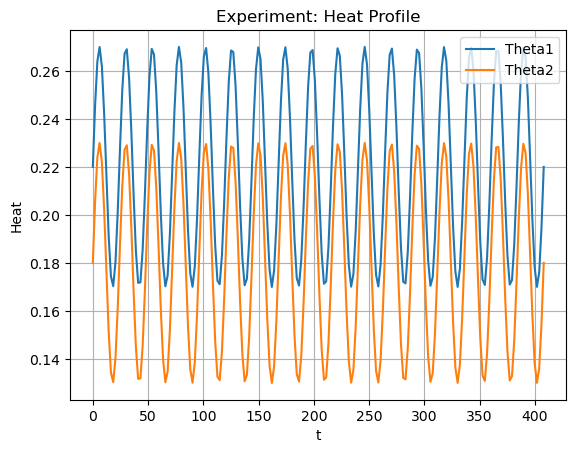

In [134]:
plt.plot(time_np, theta1_pred, label="Theta1")
plt.plot(time_np, theta2_pred, label="Theta2")
plt.xlabel("t")
plt.ylabel("Heat")
plt.title("Experiment: Heat Profile")
plt.legend()
plt.grid(True)
plt.show()

In [135]:
time_z = torch.linspace(0, 1, 200).view(-1, 1)
Temp = temp(time)
time_znp = time.cpu().numpy()*t_time

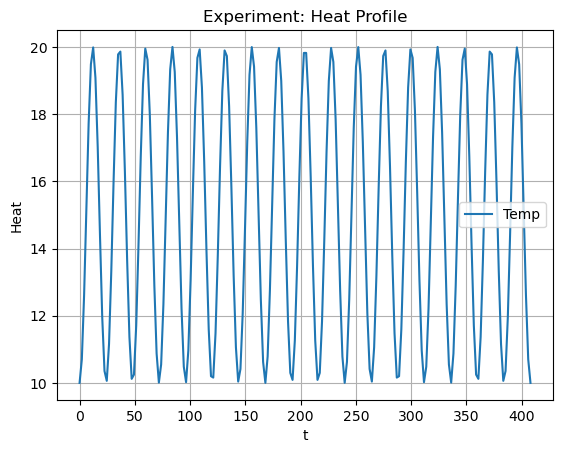

In [136]:
plt.plot(time_znp, Temp, label="Temp")
plt.xlabel("t")
plt.ylabel("Heat")
plt.title("Experiment: Heat Profile")
plt.legend()
plt.grid(True)
plt.show()